In [1]:
source('./utils.r')
source('./graphs.r')
data = get_country_data('france')

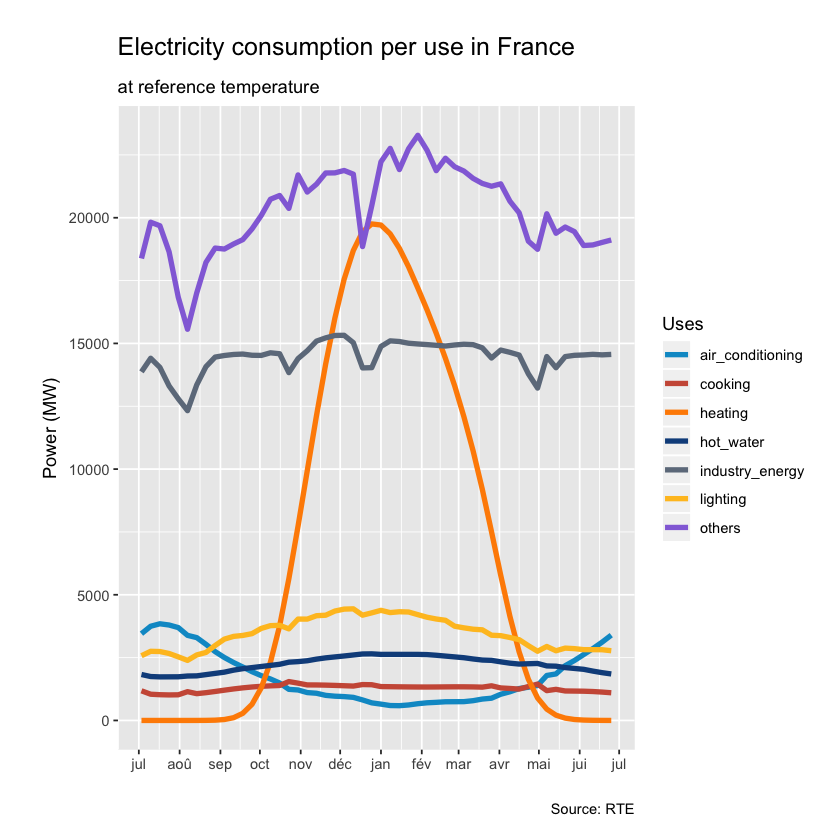

In [2]:
USE_COLORS = c('deepskyblue3', 'coral3', 'black', 'darkorange', 'dodgerblue4', 'lightsteelblue4', 'goldenrod1', 'darkorchid', 'mediumpurple')
names(USE_COLORS) = c('air_conditioning', 'cooking', 'electric_vehicules', 'heating', 'hot_water', 'industry_energy', 'lighting', 'grid_loss', 'others')

annual_use %>%
    mutate(week_index = if_else(week_index >= 26, week_index - 52, week_index)) %>%
    mutate(date = ymd('2019-01-01') + weeks(week_index)) %>%
    select(-week_index, -grid_loss, -electric_vehicules) %>%
    gather(-date, key = 'use', value = 'value') %>%

    ggplot(aes(x = date, y = value, color = use)) +
        geom_line(size = 1.5) +
        scale_x_date(date_breaks = '1 month', date_labels = "%b") + 
        scale_color_manual(values = USE_COLORS, name = "Uses") + 
        labs(
            title = "Electricity consumption per use in France",
            subtitle = "at reference temperature",
            x = "",
            y = "Power (MW)",
            caption = "Source: RTE"
        )

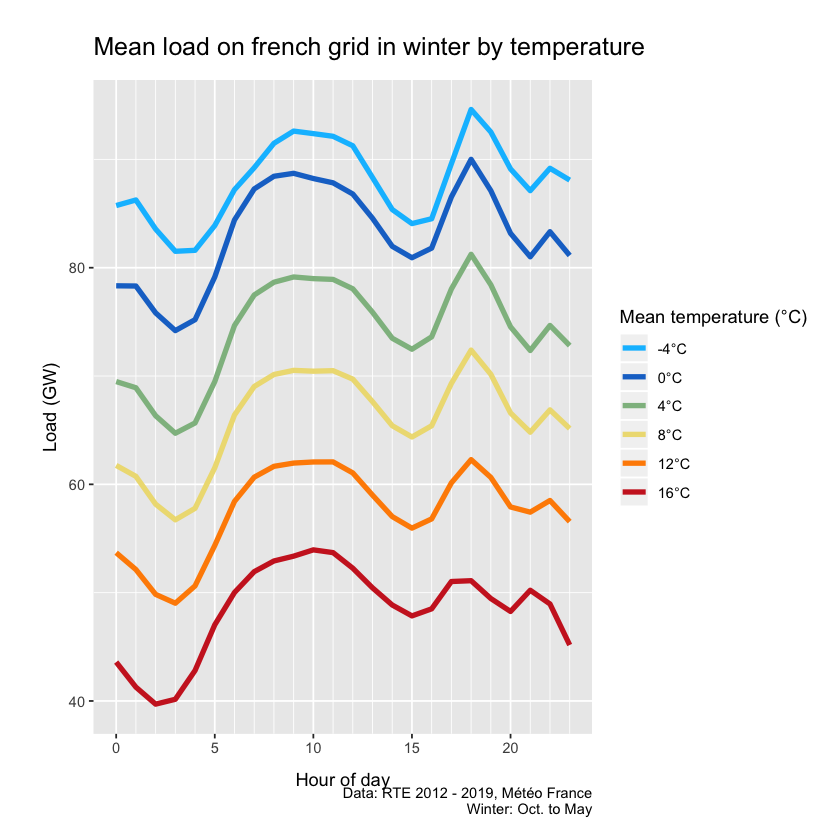

In [3]:
temp_breaks = c(-20, -4, 0, 4, 8, 12, 16)
temp_labels = paste(temp_breaks, '°C', sep = '')[2:7]
temp_colors = c('firebrick3', 'darkorange', 'lightgoldenrod', 'darkseagreen', 'dodgerblue3', 'deepskyblue1')
names(temp_colors) = rev(temp_labels)

data2 = data %>%
    add_season() %>%
    filter(season == "winter") %>%
    mutate(temp_bin = cut(
        mean_temperature, breaks = temp_breaks, right = FALSE, labels = temp_labels)
    ) %>%
    filter(!is.na(temp_bin)) %>%
    mutate(hour = hour(datetime) + 0.) %>%
    mutate(hour = if_else(minute(date) <  30, hour, hour + 0.5)) %>%
    group_by(temp_bin, hour) %>%
    summarise(conso = mean(conso))

ggplot(data2, aes( x= hour, y = conso / 1000, color = temp_bin)) +
    geom_line(size=1.5) +
    scale_x_continuous(minor_breaks = seq(0, 23)) +
    scale_color_manual(
        values = temp_colors
    ) +
    labs(
        title = "Mean load on french grid in winter by temperature",
        x = "Hour of day",
        y = "Load (GW)",
        color = "Mean temperature (°C)",
        caption = "Data: RTE 2012 - 2019, Météo France\nWinter: Oct. to May"
    )

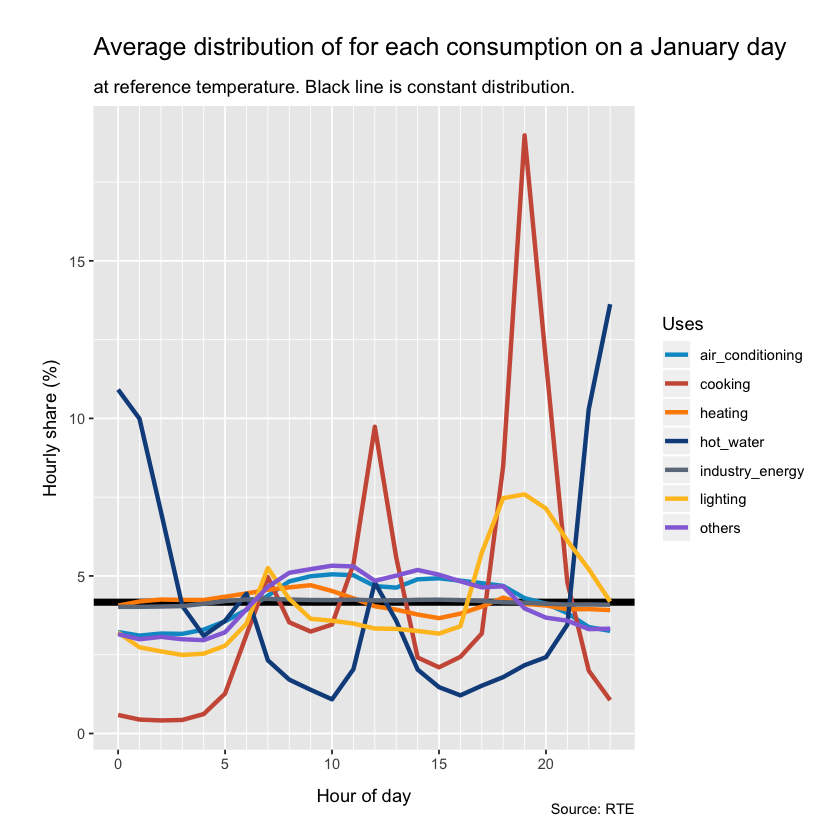

In [4]:
use_stats = january_typical_use %>%
    filter(weekday < 6) %>%
    gather(-weekday, -hour, key = 'use', value = 'value') %>%
    group_by(hour, use) %>%
    summarise(
        mean_value = mean(value)
    ) %>%
    group_by(use) %>%
    summarise(
        min_value = min(mean_value),
        median_value = median(mean_value),
        use_sum = sum(mean_value)
    )

january_typical_use %>%
    select(-grid_loss, -electric_vehicules) %>%
    filter(weekday < 6) %>%
    gather(-weekday, -hour, key = 'use', value = 'value') %>%
    group_by(hour, use) %>%
    summarise(
        value = mean(value)
    ) %>%
    left_join(use_stats, by = 'use') %>%
    mutate(value = value / use_sum * 100) %>%
    ggplot(aes(x = hour, y = value, color = use)) +
        geom_hline(yintercept = 1 / 24 * 100, size = 2) +
        geom_line(size = 1.25) +
        scale_x_continuous(minor_breaks = seq(0, 23)) +
        scale_color_manual(values = USE_COLORS, name = "Uses") +
        labs(
            title = "Average distribution of for each consumption on a January day",
            subtitle = "at reference temperature. Black line is constant distribution.",
            x = "Hour of day",
            y = "Hourly share (%)",
            caption = "Source: RTE"
        )

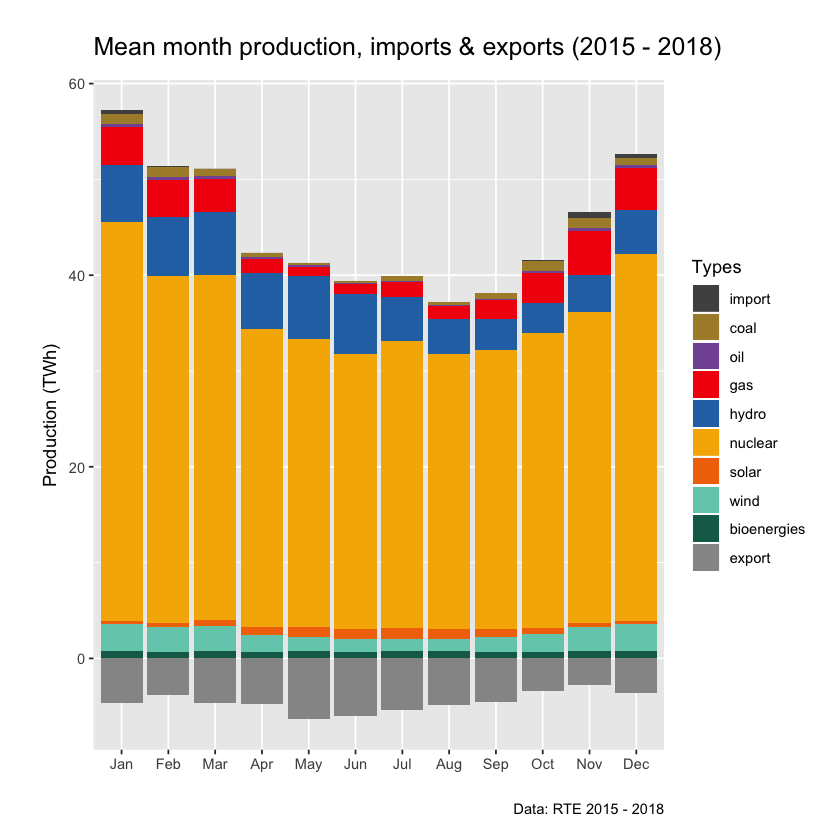

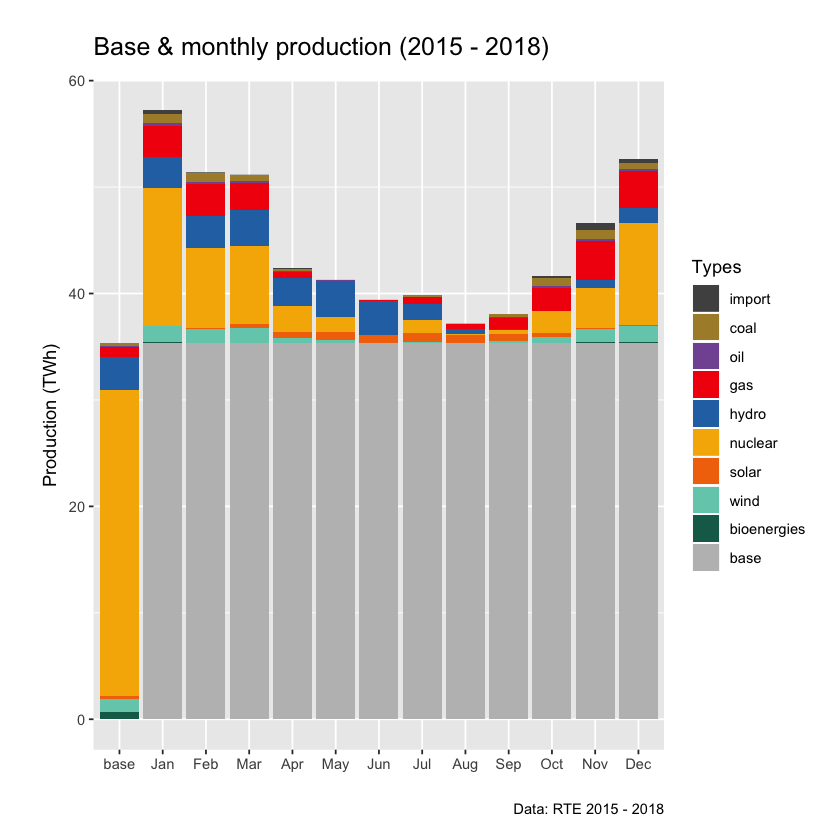

In [5]:
start_year = 2015
end_year = 2018
year_count = end_year - start_year + 1

# compute production by type and by month
stats_by_month = data %>%
    filter(year >= start_year & year <= end_year) %>%
    add_month() %>%
    add_import_export() %>%
    add_prod() %>%
    group_by(month) %>%
    summarise(
        bioenergies = sum(bioenergies),
        nuclear = sum(nuclear),
        gas = sum(gas),
        coal = sum(coal),
        oil = sum(oil),
        wind = sum(wind),
        solar = sum(solar),
        hydro = sum(hydro),
        import = sum(import),
        export = -sum(export),
    ) %>%
    gather(-month, key = 'type', value = 'value') %>%
    mutate(value = value * 0.5 * 10^(-6) / year_count)

# graph of production types by month
stats_by_month$type = factor(stats_by_month$type, levels = rev(PROD_TYPES_ORDER_2))
stats_by_month %>%
  mutate(month_label = month(month, TRUE, TRUE, locale='en_US')) %>%
  ggplot(aes(x = month_label, y = value, fill = type)) +
    geom_col() +
    scale_fill_manual(values = PROD_TYPES_COLORS) +
    labs(
      title = paste('Mean month production, imports & exports (', start_year, ' - ', end_year, ')', sep=''),
      x = '',
      y = 'Production (TWh)',
      fill = 'Types',
      caption = paste('Data: RTE ', start_year, ' - ', end_year, sep='')
    )

base_type_prod = stats_by_month %>%
  filter(type != 'export') %>%
  group_by(type) %>%
  summarise(base_prod = min(value))

base_prod = base_type_prod %>%
  summarise(prod = sum(base_prod)) %>%
  pull()

monthly_type_prod = stats_by_month %>%
  filter(type != 'export') %>%
  left_join(base_type_prod, by = 'type') %>%
  mutate(prod = value - base_prod) %>%
  select(-value, -base_prod)

# graph of monthly production types
monthly_graph(base_type_prod, monthly_type_prod)

$heating_kg_kwh
[1] 0.1381781

$monthly_graph


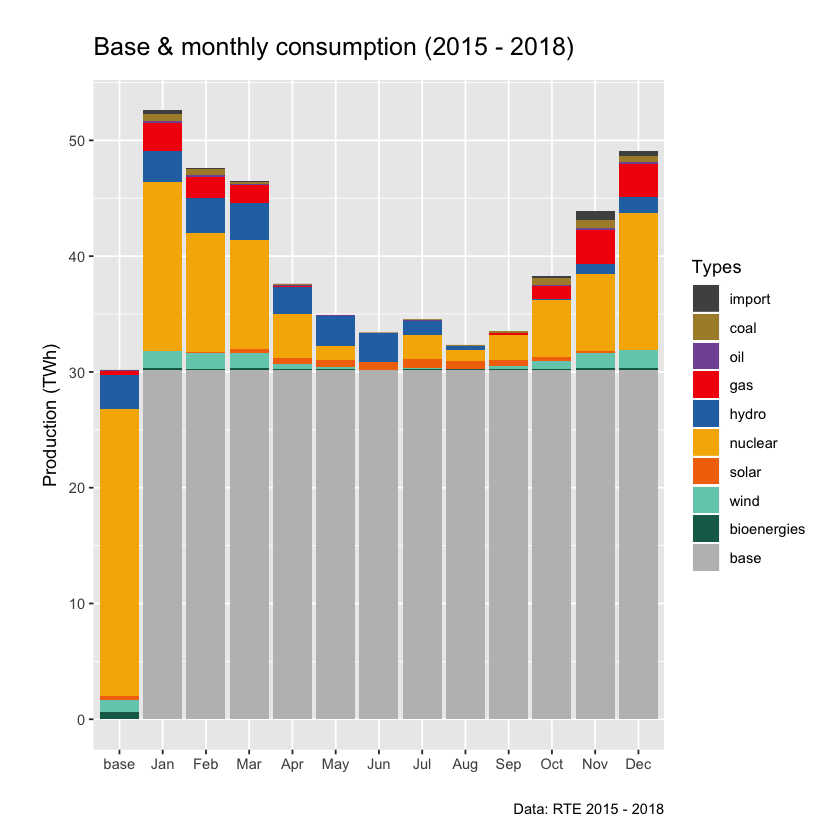

In [6]:
source('./monthly_heating_analysis.r')
data %>%
  filter(year >= start_year & year <= end_year) %>%
  add_prod() %>%
  add_import_export() %>%
  add_marginal_export_dispatch() %>%
  mutate(coal = conso_coal) %>%
  mutate(gas = conso_ccg + gas_cogen + gas_turbine + gas_others) %>%
  mutate(export = remaining_export) %>%
  mutate(conso_factor = (conso - hydro_pumped_storage) / (conso - hydro_pumped_storage + remaining_export)) %>%
  mutate(
    bioenergies = bioenergies * conso_factor,
    nuclear = nuclear * conso_factor,
    gas = gas * conso_factor,
    coal = coal * conso_factor,
    oil = oil * conso_factor,
    wind = wind * conso_factor,
    solar = solar * conso_factor,
    hydro = hydro * conso_factor,
  ) %>%
  get_heating_impact_by_monthly_analysis(ghg_factors = ADEME_GHG_FACTORS, import_ghg_factor = 1.06, loss_rate = 0.1)

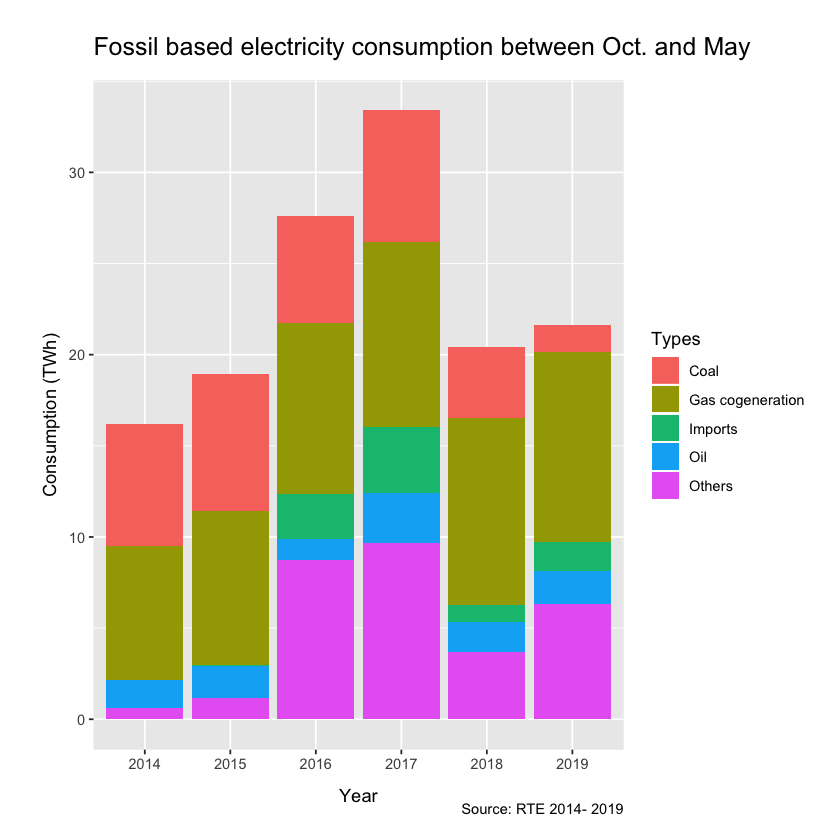

In [7]:
data %>%
    add_month() %>%
    filter(year > 2013, month < 5 | month > 9) %>%
    add_prod() %>%
    add_import_export() %>%
    add_marginal_export_dispatch() %>%
    group_by(year) %>%
    summarise(
        'Others' = (sum(conso_ccg) + sum(gas_turbine) + sum(gas_others)) * MW_TO_KWH / 10^9,
        'Gas cogeneration' = sum(gas_cogen) * MW_TO_KWH / 10^9,
        'Imports' = sum(import) * MW_TO_KWH / 10^9,
        'Coal' = sum(coal) * MW_TO_KWH / 10^9,
        'Oil' = sum(oil) * MW_TO_KWH / 10^9,
    ) %>%
    gather(-year, key = 'type', value = 'value') %>%
    ggplot(aes(x = paste(year), y = value, fill = type)) + 
        geom_col() +
        labs(
            title = 'Fossil based electricity consumption between Oct. and May',
            x = 'Year',
            y = 'Consumption (TWh)',
            fill = 'Types',
            caption = 'Source: RTE 2014- 2019'
        )
